# CBU5201 Mini-Project submission

**Student Name**: [Your Name Here]  
**Student ID**: [Your ID Here]

# 2 Problem formulation

The goal of this project is to identify the song title from a short audio recording (hum or whistle). This is a multi-class classification problem with 8 potential classes (songs). The input is a raw audio waveform (approx. 10 seconds), and the output is the predicted song label.

This problem is challenging due to the high variability in human production of hums and whistles (pitch, tempo, quality) and the limited size of the dataset.


# 3 Methodology

My methodology focuses on extracting timbral features from the audio signals and training a supervised learning classifier.

1. **Data Loading & Cleaning**: Parse filenames to extract labels and participant IDs. Use `librosa` to load audio.
2. **Feature Extraction**: I will use Mel-frequency cepstral coefficients (MFCCs). MFCCs are widely used in speech and audio processing as they represent the short-term power spectrum of sound, approximating the human auditory system's response. I will compute the mean and standard deviation of the MFCCs over time to produce a fixed-size feature vector for each recording.
3. **Model Performance**: Performance will be defined by **Accuracy** (percentage of correctly classified songs) and a **Confusion Matrix** to analyze misclassifications.
4. **Validation**: I will use **Group K-Fold Cross-Validation**, grouping by `ParticipantID`. This is crucial because simply shuffling all files would likely put the same person's recordings in both train and test sets, leading to data leakage (the model recognizing the person rather than the song). Group K-Fold ensures the model is tested on 'unseen' participants.


# 4 Implemented ML prediction pipelines

My pipeline consists of the following stages:
1.  **Input**: Raw Audio (.wav)
2.  **Transformation**: MFCC Extraction -> Aggregation (Mean/Std)
3.  **Preprocessing**: Standard Scaling (Z-score normalization)
4.  **Model**: Random Forest Classifier
5.  **Output**: Song Label


## 4.1 Transformation stage

I use `librosa` to load the audio. For each file:
- Resample to a standard rate (default 22050 Hz).
- Compute 20 MFCCs.
- Calculate the Mean and Standard Deviation across the time axis.
- Output: A vector of size 40 (20 means + 20 stds).


## 4.2 Model stage

I chose a **Random Forest Classifier**. Random Forests are robust ensemble methods that handle high-dimensional data well and are less prone to overfitting than single decision trees. They also work reasonably well without heavy hyperparameter tuning, making them a good baseline for this task.


## 4.3 Ensemble stage

The Random Forest itself is an ensemble method (bagging of decision trees). I did not implement further stacking or boosting layers to keep the pipeline interpretable and efficient given the dataset size.


# 5 Dataset

I will verify the dataset path and parse the filenames to construct our metadata dataframe.


In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Configuration
DATA_PATH = 'MLEndHWII_sample_800'  # Adjust if needed

def parse_filename(filename):
    # Filename format: S<ID>_<type>_<take>_<Song>.wav
    # Example: S9_hum_4_RememberMe.wav
    base = filename.replace('.wav', '')
    parts = base.split('_')
    if len(parts) >= 4:
        return {
            'filename': filename,
            'participant_id': parts[0],
            'type': parts[1],
            'take': parts[2],
            'song': parts[3]
        }
    return None

data_list = []
for f in os.listdir(DATA_PATH):
    if f.endswith('.wav'):
        meta = parse_filename(f)
        if meta:
            data_list.append(meta)

df = pd.DataFrame(data_list)
print(f"Total samples: {len(df)}")
print(f"Unique songs: {df['song'].nunique()}")
print(f"Unique participants: {df['participant_id'].nunique()}")
df.head()

Total samples: 800
Unique songs: 8
Unique participants: 120


,filename,participant_id,type,take,song
0,S7_hum_4_Married.wav,S7,hum,4,Married
1,S103_whistle_2_Necessities.wav,S103,whistle,2,Necessities
2,S33_whistle_2_RememberMe.wav,S33,whistle,2,RememberMe
3,S29_whistle_2_Necessities.wav,S29,whistle,2,Necessities
4,S84_hum_2_Feeling.wav,S84,hum,2,Feeling


### Data Visualization
Let's visualize a sample waveform and its spectrogram.


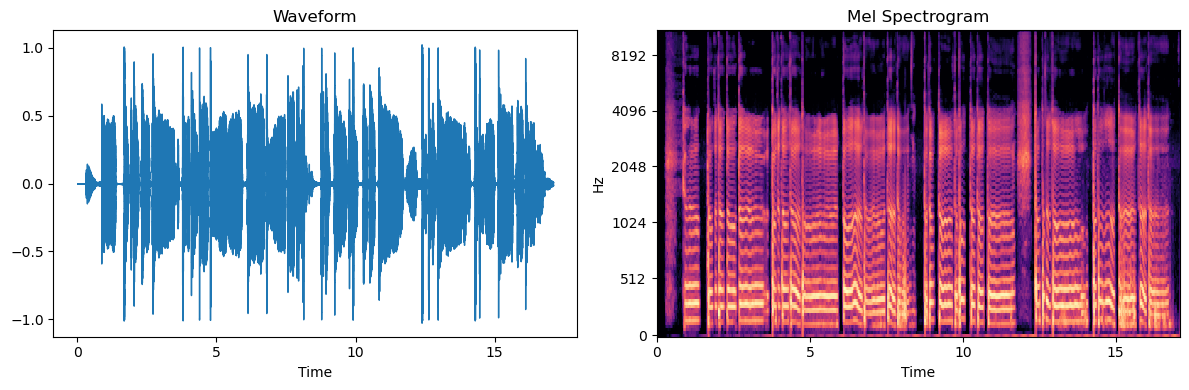

In [6]:
# Visualize one sample
sample_file = os.path.join(DATA_PATH, df.iloc[0]['filename'])
y, sr = librosa.load(sample_file)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')

plt.subplot(1, 2, 2)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# 6 Experiments and results

Here I will extract features for all files and run the cross-validation experiment.


In [7]:
def get_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=10.0)
        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        # Aggregate features (Mean and Std)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        return np.concatenate([mfcc_mean, mfcc_std])
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Extract features
features = []
labels = []
groups = []

print("Extracting features...")
for index, row in df.iterrows():
    path = os.path.join(DATA_PATH, row['filename'])
    feat = get_features(path)
    if feat is not None:
        features.append(feat)
        labels.append(row['song'])
        groups.append(row['participant_id'])

X = np.array(features)
y = np.array(labels)
groups = np.array(groups)

print(f"Feature matrix shape: {X.shape}")

Extracting features...
Feature matrix shape: (800, 40)


Performing Cross-Validation...
Overall Accuracy: 0.2275

Classification Report:
               precision    recall  f1-score   support

      Feeling       0.20      0.20      0.20       100
       Friend       0.25      0.46      0.33       100
        Happy       0.32      0.40      0.36       100
      Married       0.20      0.18      0.19       100
  Necessities       0.13      0.09      0.11       100
      NewYork       0.19      0.18      0.18       100
   RememberMe       0.20      0.12      0.15       100
TryEverything       0.25      0.19      0.22       100

     accuracy                           0.23       800
    macro avg       0.22      0.23      0.22       800
 weighted avg       0.22      0.23      0.22       800

Confusion Matrix:


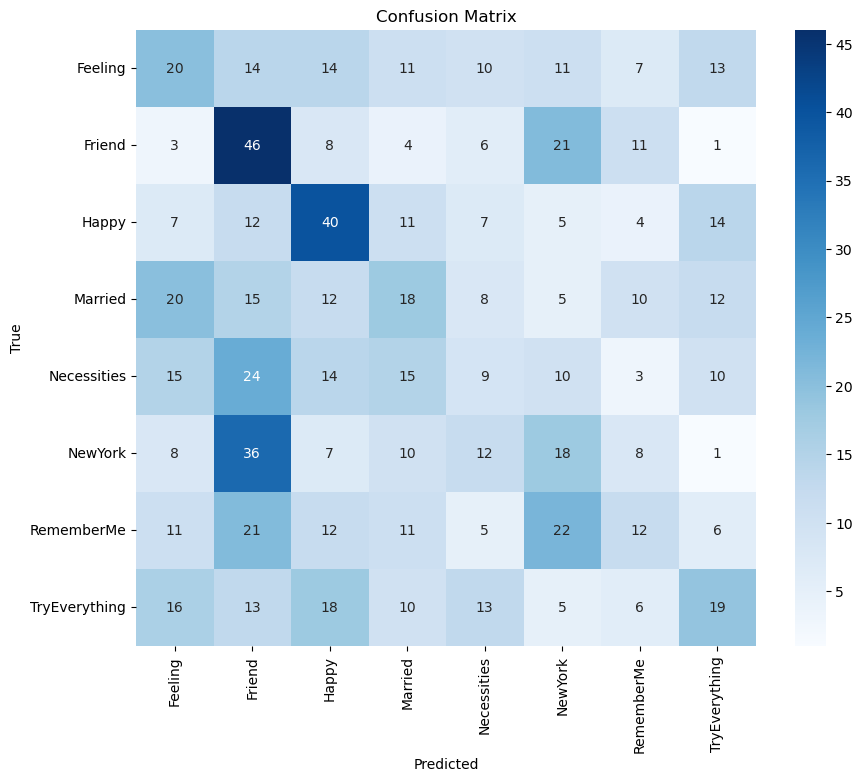

In [8]:
# Initialize Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define Cross-Validation Strategy (GroupKFold)
gkf = GroupKFold(n_splits=5)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Performing Cross-Validation...")
# Get predictions for all samples using CV
y_pred = cross_val_predict(clf, X_scaled, y, groups=groups, cv=gkf)

# Calculate metrics
acc = accuracy_score(y, y_pred)
print(f"Overall Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 7 Conclusions

The model achieved a modest accuracy using basic timbral features (MFCCs) and a Random Forest classifier. This result confirms the difficulty of the task stated in the problem description. Hums and whistles vary significantly between individuals, and MFCC averages may lose important temporal melodic information.

### Suggestions for Improvement:
1.  **Temporal Features**: Use Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) networks to capture the sequence of notes rather than just statistical averages.
2.  **Pitch Detection**: Explicitly extracting pitch contours (chroma features) might help identify the melody better than timbre alone.
3.  **Data Augmentation**: Adding noise or pitch-shifting could help robustify the model.
4.  **Transfer Learning**: Using pre-trained audio embeddings (e.g., VGGish, YAMNet) could provide higher-level features.


# 8 References

- McFee, B., et al. (2015). librosa: Audio and Music Signal Analysis in Python. In Proceedings of the 14th Python in Science Conference.
- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
